# Plausi der Messwerte der Wetterstationen der Wasserschutzpolizei Zürich
Datum: 17.01.2023

**Ausgangslage:**

Früher, bis 2022, lieferte Hr. Namnick jährlich per Mail die Jahresdaten der Wetterstationen. Danach wurden die neu gelieferten Jahresdaten in SAS eingelesen, die Variabelnamen standardisiert und richtig sortiert und letztlich die neuen mit den bisherigen Jahren zeitlich sortiert zusammengehängt.Odi hat dann zusätzlich noch ein [**Python-Skript serverseitig**](https://github.com/opendatazurich/ogd-data-processing/blob/main/sid_wapo_wetterstationen/convert_csv.py) generiert um aus der mitgelieferten `utc` das `cet` Datum aus dem Datumsfeld zu berechnen. Mit diesem Notebook können wir das aber gleich beim Update erledigen. Die Datenaufbereitung habe ich 2022 mit Jupyter Lab gemacht, siehe [**Github**](https://github.com/DonGoginho/myPy/blob/main/update_ogd/update_sid_wapo_wetterstationen.ipynb )

**Neu seit 2023:**

Seit Ende 2022 werden die Daten täglich aktualisiert und als ein grosser Datensatz zur Verfügung gestellt. Siehe dazu das [**wapo-Skript auf Github**](https://github.com/opendatazurich/opendatazurich.github.io/tree/master/automation/wapo_wetterstationen )

Dadurch ist nun das Einlesen und Zusammenfügen der Jahresbestände mit dem aktuellen Jahr nicht mehr notwendig, wie beim früheren Skript.





**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen

## Einstellungen
### Importiere die notwendigen Packages

In [1]:
#%pip install openpyxl geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [2]:
import pandas as pd
import datetime
import time
import numpy as np

import requests
import io

import pivottablejs
from pivottablejs import pivot_ui
import altair as alt


import matplotlib.pyplot as plt

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import `datetime` und `from datetime import datetime`, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")

date_day_a_week_ago = (datetime.datetime.now() - datetime.timedelta(days=7)).date()
day_a_week_ago = date_day_a_week_ago.strftime('%Y-%m-%d')

lastYear = (datetime.datetime.now() - datetime.timedelta(days=365)).date().strftime('%Y')

print(now," vor einer Woche: ", day_a_week_ago)


2023-01-20  vor einer Woche:  2023-01-13


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(lastYear, aktuellesJahr, 
      aktuellerMonat,
      'datenstand: ', 
      selectedMonat,
     int_times)


2022 2023 1 datenstand:  -1 time.struct_time(tm_year=2023, tm_mon=1, tm_mday=20, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=20, tm_isdst=-1)


## Importiere die bereits veröffentlichten und die aktuelle Zeitreihen der Messstationen 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**Statische Pfade in DWH-Dropzones**

In [8]:
#dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [9]:
#dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [10]:
#ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [11]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

**BITTE HIER ANPASSEN**

In [12]:
package_name = "sid_wapo_wetterstationen"

In [13]:
messstationen = ["mythenquai_", "tiefenbrunnen_"]


In [14]:
endings = ["seit2007-heute"]

In [15]:
dataset_name = "messwerte_"+messstationen[0]+endings[0]+".csv"
print(dataset_name)

messwerte_mythenquai_seit2007-heute.csv


### Importiere die Datensätze 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?


In [16]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [17]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+"messwerte_"
            print("fp lautet:"+fp)
    else:
        #fp_ = ckan_prod_url+package_name+'/download/'+"messwerte_"+messstation+ending+".csv"
        fp = ckan_prod_url+package_name+'/download/'+"messwerte_"
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+"messwerte_"
        print("fp lautet:"+fp)
    else:
        fp = ckan_integ_url+package_name+'/download/'+"messwerte_"
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_


#### Importiere die Datensätze für Mythenquai und Tiefenbrunnen

Dieser Datensatz enthält zwei Ressourcen. 

In [18]:
  # Read the data
dfs=[]

if data_source == "web":    
    for messstation in messstationen:              
        for ending in endings:
            url= fp+messstation+ending+".csv"
            r = requests.get(url, verify=False)
            r.encoding = 'utf-8'
            df = pd.read_csv(
                io.StringIO(r.text)
                , parse_dates=['timestamp_utc']
                , sep=','
                ,low_memory=False)                
            new_df_name = 'df_'+ messstation + ending.replace('-','_')
            print(new_df_name)
            exec(f'{new_df_name} = df.copy()')
            #print(new_df_name)
            dfs.append(new_df_name)            
    print("Ende Loop for dropzone: ")
    
else: 
    for messstation in messstationen:        
        print("Aktuell gibt es keine Daten auf der Dropzone mehr. Sie werden per CKAN-API hoch gepushed.")         
            
    print("Ende Loop for dropzone: ")          

#https://stackoverflow.com/questions/40973687/create-new-dataframe-in-pandas-with-dynamic-names-also-add-new-column

df_mythenquai_seit2007_heute
df_tiefenbrunnen_seit2007_heute
Ende Loop for dropzone: 


In [19]:
df_zeitreihe_my = df_mythenquai_seit2007_heute
df_zeitreihe_tb = df_tiefenbrunnen_seit2007_heute
#dfs

## Datentests

In [20]:
df_zeitreihe_my.head(3).T
df_zeitreihe_tb.head(3).T

,0,1,2
timestamp_utc,2007-04-15 09:30:00+00:00,2007-04-15 09:40:00+00:00,2007-04-15 09:50:00+00:00
timestamp_cet,2007-04-15T11:30:00+02:00,2007-04-15T11:40:00+02:00,2007-04-15T11:50:00+02:00
air_temperature,17.4,16.7,17.0
water_temperature,11.9,12.1,12.0
wind_gust_max_10min,0.6,0.5,0.7
wind_speed_avg_10min,0.0,0.1,0.1
wind_force_avg_10min,0.0,0.1,0.1
wind_direction,154,150,145
windchill,17.4,16.7,17.0
barometric_pressure_qfe,973.2,973.3,973.3


In [21]:
# drop columns that have no values
# data2betested.dropna(how='all', axis=1, inplace=True)

**Mythenquai**: Zeige Infos zu den Attributen

In [22]:
df_zeitreihe_my.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818648 entries, 0 to 818647
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   timestamp_utc            818648 non-null  datetime64[ns, UTC]
 1   timestamp_cet            818648 non-null  object             
 2   air_temperature          818648 non-null  float64            
 3   water_temperature        718252 non-null  float64            
 4   wind_gust_max_10min      818648 non-null  float64            
 5   wind_speed_avg_10min     818648 non-null  float64            
 6   wind_force_avg_10min     818648 non-null  float64            
 7   wind_direction           818648 non-null  int64              
 8   windchill                818648 non-null  float64            
 9   barometric_pressure_qfe  813907 non-null  float64            
 10  precipitation            718252 non-null  float64            
 11  dew_point    

**Tiefenbrunnen**: Zeige Infos zu den Attributen

In [23]:
df_zeitreihe_my.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818648 entries, 0 to 818647
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   timestamp_utc            818648 non-null  datetime64[ns, UTC]
 1   timestamp_cet            818648 non-null  object             
 2   air_temperature          818648 non-null  float64            
 3   water_temperature        718252 non-null  float64            
 4   wind_gust_max_10min      818648 non-null  float64            
 5   wind_speed_avg_10min     818648 non-null  float64            
 6   wind_force_avg_10min     818648 non-null  float64            
 7   wind_direction           818648 non-null  int64              
 8   windchill                818648 non-null  float64            
 9   barometric_pressure_qfe  813907 non-null  float64            
 10  precipitation            718252 non-null  float64            
 11  dew_point    

Beschreibe nicht numerische Attribute

In [24]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format, datetime_is_numeric=True):
        display(df_zeitreihe_my.describe(exclude='number'))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [25]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.1f}'.format):
        display(df_zeitreihe_my.describe(include='number'))
except:
    print("No numercial data in dataset.")

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
count,"818,648.0","718,252.0","818,648.0","818,648.0","818,648.0","818,648.0","818,648.0","813,907.0","718,252.0","818,648.0","718,252.0","818,648.0","718,252.0"
mean,11.6,13.3,3.6,1.9,1.8,183.9,10.4,975.3,0.0,6.8,133.3,75.0,405.9
std,8.0,7.0,2.6,1.4,1.3,106.1,8.6,17.3,0.2,6.5,291.4,16.5,0.2
min,-13.4,0.1,-0.1,0.0,0.0,0.0,-25.6,930.7,0.0,-17.2,0.0,16.0,405.2
25%,5.2,6.3,1.8,0.9,1.0,101.0,3.6,966.2,0.0,1.9,0.0,64.0,405.9
50%,11.3,13.0,3.0,1.7,1.7,175.0,10.2,971.0,0.0,6.8,6.0,79.0,405.9
75%,17.5,19.7,4.8,2.6,2.4,286.0,16.9,977.0,0.0,12.1,152.0,87.0,406.0
max,37.7,28.2,32.0,17.1,16.8,360.0,37.8,"1,037.5",17.0,24.6,"4,293.0",100.0,406.5


Beschreibe kurz die Datensätze

In [26]:
print(f'The dataset for Mythenquai has {df_zeitreihe_my.shape[0]:,.0f} rows (observations) and {df_zeitreihe_my.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {df_zeitreihe_my.duplicated().sum()} exact duplicates in the data.')

The dataset for Mythenquai has 818,648 rows (observations) and 15 columns (variables).
There seem to be 4878 exact duplicates in the data.


In [27]:
print(f'The dataset for Tiefenbrunnen has {df_zeitreihe_tb.shape[0]:,.0f} rows (observations) and {df_zeitreihe_tb.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {df_zeitreihe_tb.duplicated().sum()} exact duplicates in the data.')
#df_zeitreihe_tb.isnull().sum()

The dataset for Tiefenbrunnen has 886,209 rows (observations) and 15 columns (variables).
There seem to be 73783 exact duplicates in the data.


### Duplikate auflisten

**Mythenquai**

In [28]:
# find duplicate rows
duplicate_rows_my = df_zeitreihe_my[df_zeitreihe_my.duplicated()]
#duplicate_rows_my.set_index("timestamp_utc")


AggDupli_my = duplicate_rows_my\
    .groupby(['timestamp_utc', 'air_temperature', 'water_temperature']) \
    .agg(cnt_rows=('water_temperature', 'count')) \
    .sort_values('cnt_rows', ascending=False) 

AggDupli_my.reset_index()

,timestamp_utc,air_temperature,water_temperature,cnt_rows
0,2023-01-18 23:20:00+00:00,0.0,6.2,7
1,2023-01-16 00:10:00+00:00,2.9,6.6,7
2,2023-01-10 00:30:00+00:00,3.7,6.9,7
3,2023-01-18 23:50:00+00:00,-0.1,6.2,7
4,2023-01-19 00:00:00+00:00,-0.1,6.2,7
...,...,...,...,...
1345,2023-01-18 16:10:00+00:00,1.6,6.2,1
1346,2023-01-18 16:20:00+00:00,1.5,6.2,1
1347,2023-01-18 16:30:00+00:00,1.5,6.2,1
1348,2023-01-18 16:40:00+00:00,1.3,6.2,1


**Tiefenbrunnen**

In [29]:
# find duplicate rows
duplicate_rows_tb = df_zeitreihe_tb[df_zeitreihe_tb.duplicated()]
#duplicate_rows_tb.set_index("timestamp_utc")


AggDupli_tb = duplicate_rows_tb\
    .groupby(['timestamp_utc', 'air_temperature', 'water_temperature']) \
    .agg(cnt_rows=('water_temperature', 'count')) \
    .sort_values('cnt_rows', ascending=False) 

AggDupli_tb.reset_index()

,timestamp_utc,air_temperature,water_temperature,cnt_rows
0,2022-09-21 22:00:00+00:00,11.7,19.2,13
1,2022-10-03 22:00:00+00:00,11.9,16.5,12
2,2022-09-25 22:00:00+00:00,11.5,18.6,12
3,2022-10-29 22:00:00+00:00,13.3,16.0,12
4,2022-10-16 22:00:00+00:00,14.7,16.6,12
...,...,...,...,...
15685,2022-11-25 16:40:00+00:00,8.7,11.5,1
15686,2022-11-25 16:50:00+00:00,8.5,11.5,1
15687,2022-11-25 17:00:00+00:00,8.4,11.5,1
15688,2022-11-25 17:10:00+00:00,8.2,11.5,1


### Wie viele Missings gibt es in den Datensätzen?

In [30]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno


<AxesSubplot:>

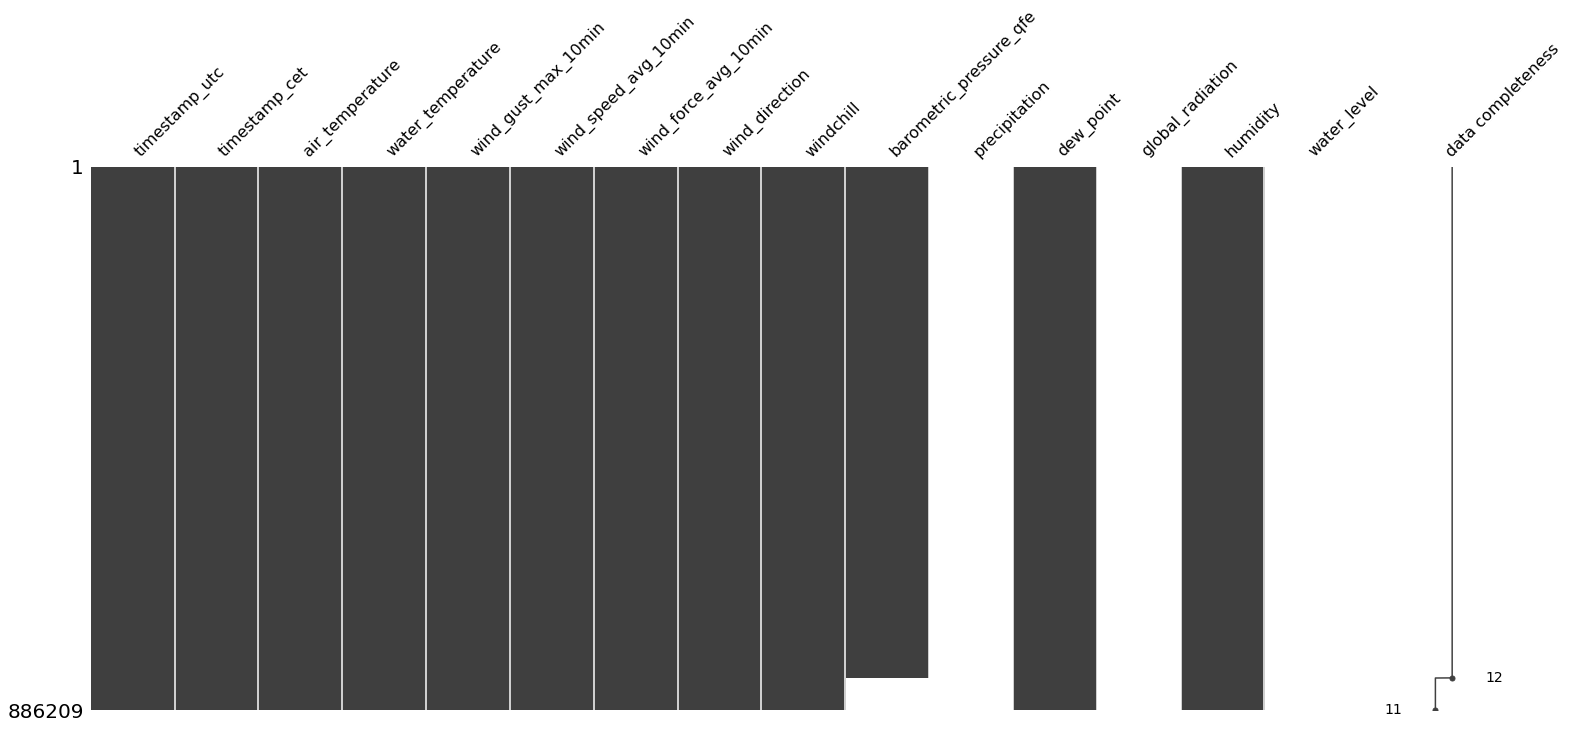

In [31]:
msno.matrix(df_zeitreihe_tb, labels=True, sort='descending')

<AxesSubplot:>

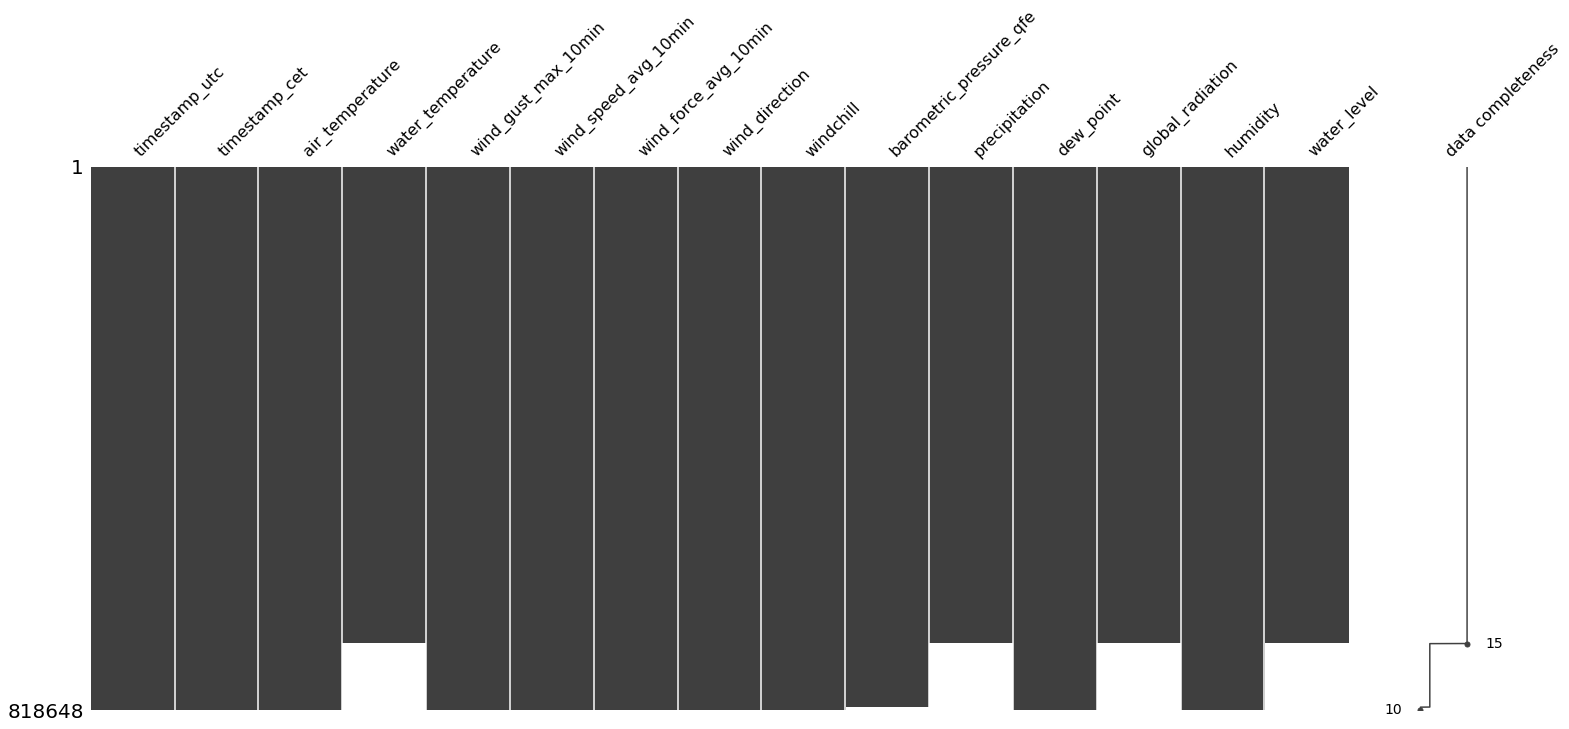

In [32]:
msno.matrix(df_zeitreihe_my, labels=True, sort='descending')

<AxesSubplot:>

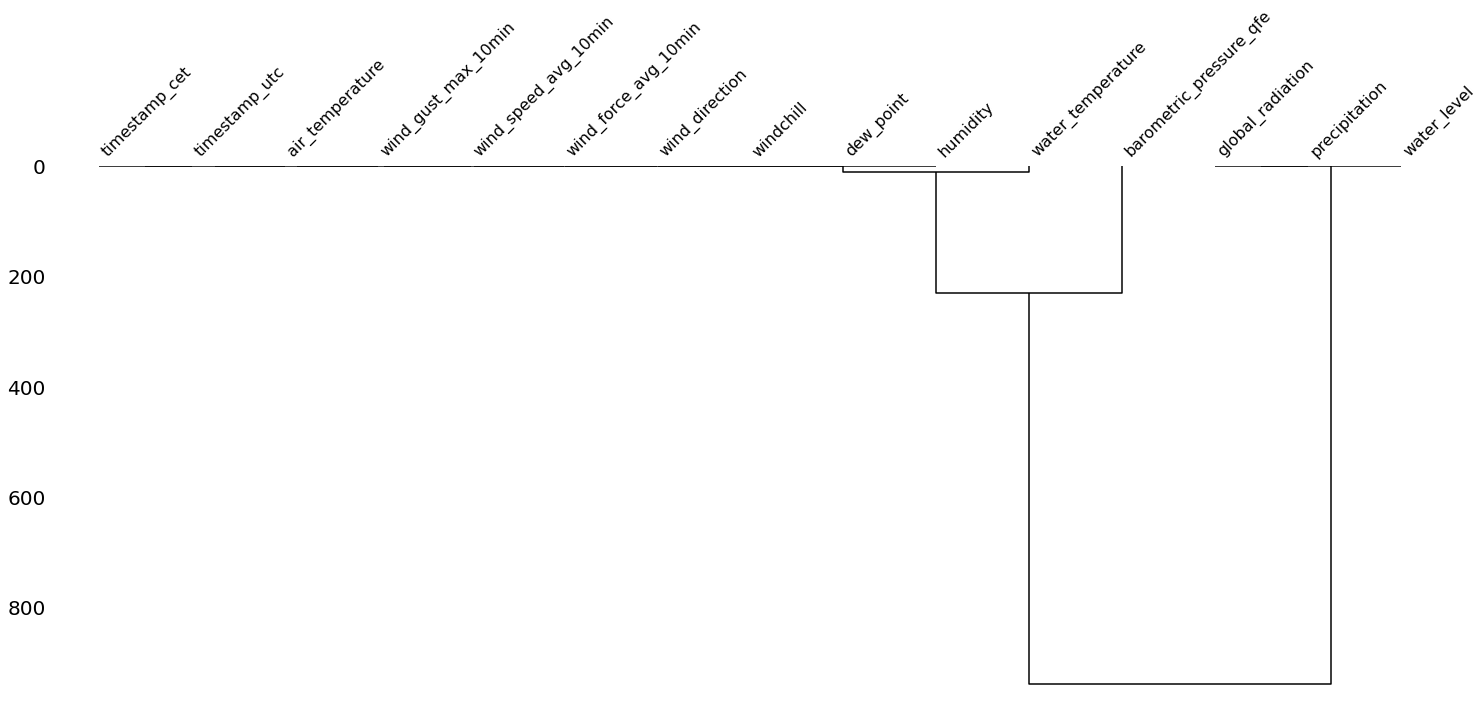

In [33]:
msno.dendrogram(df_zeitreihe_tb)

<AxesSubplot:>

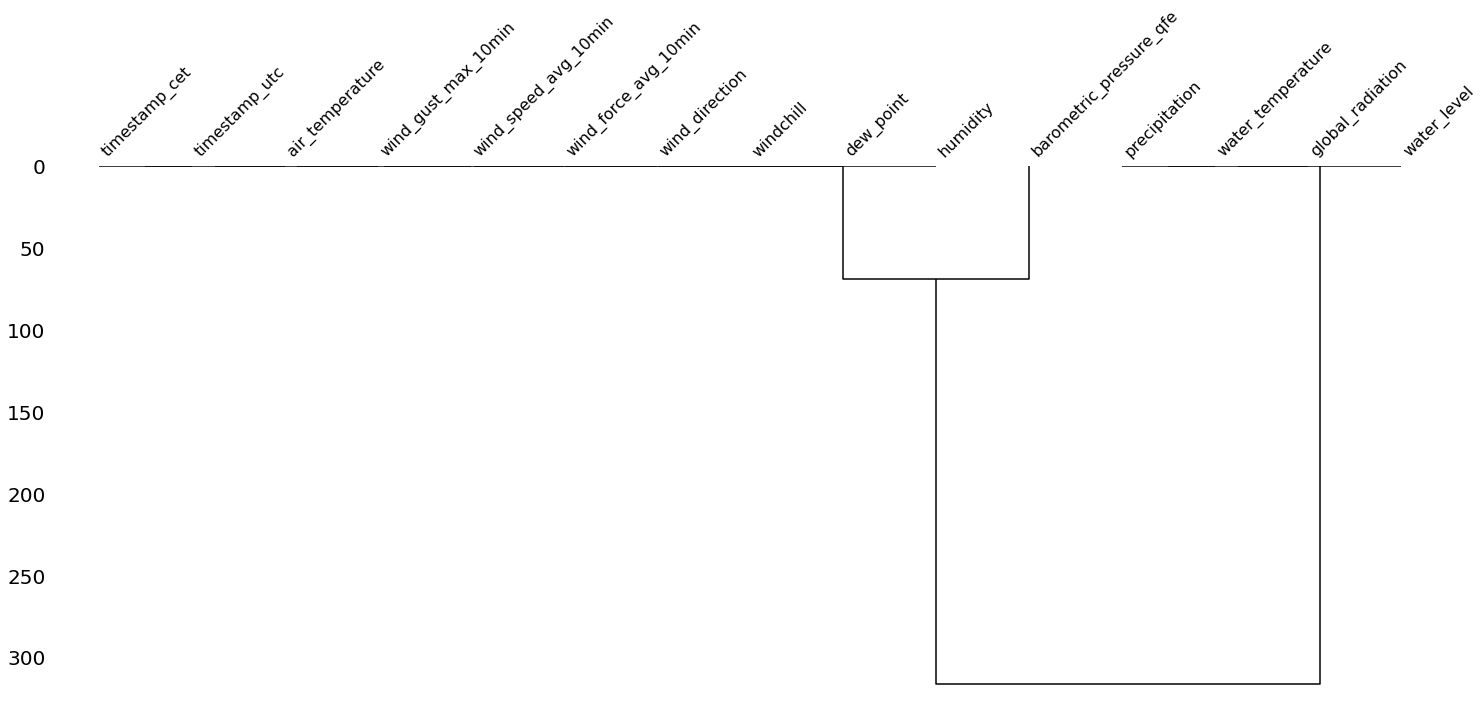

In [34]:
msno.dendrogram(df_zeitreihe_my)

In [35]:
#msno.heatmap(df_zeitreihe_tb)

In [36]:
#msno.heatmap(df_zeitreihe_my)

Zeige ein Histogramm für jedes numerische Attribut

In [37]:
# plot a histogram for each numerical feature
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)


**Tiefenbrunnen**

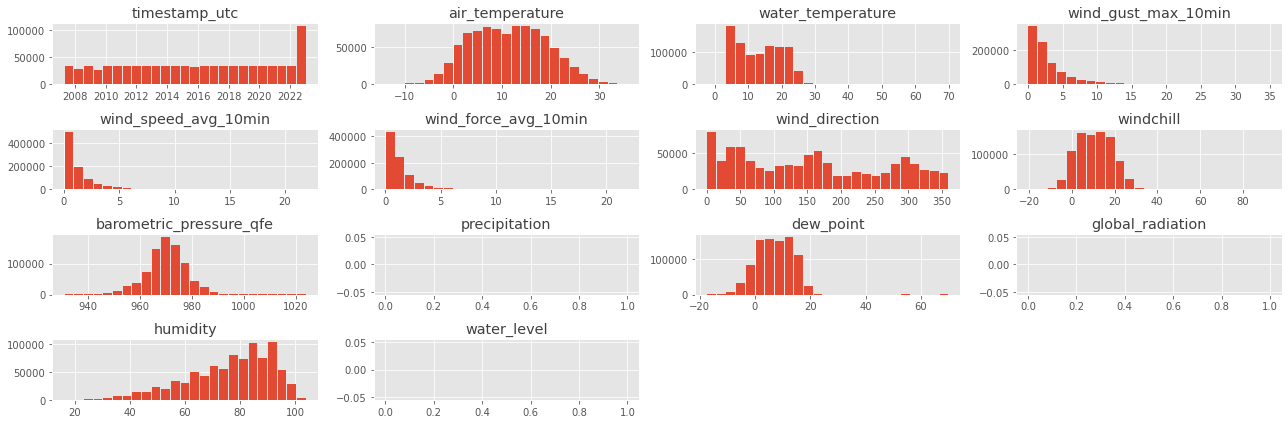

In [38]:
try:
    df_zeitreihe_tb.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

**Mythenquai**

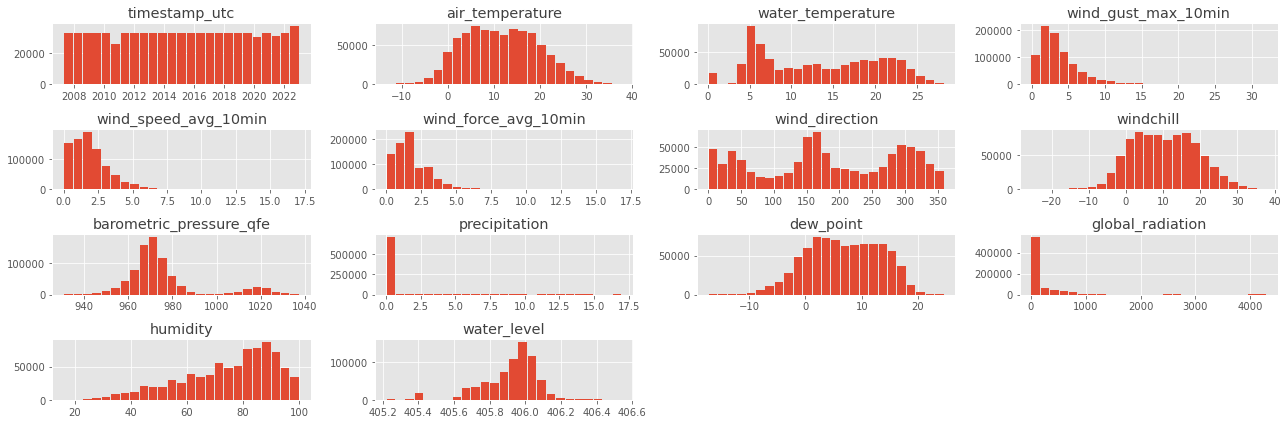

In [39]:
try:
    df_zeitreihe_my.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [40]:
from IPython.display import Markdown as md

In [41]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

NameError: name 'ckan_integ_url' is not defined

In [ ]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

## Grafische Auswertungen
### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [42]:
#df_zeitreihe_my.columns
#df_zeitreihe_tb.columns

In [43]:
df_zeitreihe_my = df_zeitreihe_my.set_index("timestamp_utc")

In [44]:
df_zeitreihe_tb = df_zeitreihe_tb.set_index("timestamp_utc")

1. first we create the sums per week
weekly_means = df_zeitreihe_tb.resample("W").mean()
2. then we generate the weekly means for each quarter
quarterly_means = df_zeitreihe_tb.resample("Q").mean()
quarterly_median = df_zeitreihe_tb.resample("Q").median()
3. for readability we'll revert the values back to integers
#weekly_means.dropna().astype(int).head(5)
#weekly_means
#quarterly_means
#quarterly_median

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

Daten zu gross hierfür... Stürzt ab

In [45]:
#from pivottablejs import pivot_ui

#pivot_ui(df_zeitreihe_tb)

### Zeitpunkte und Zeiträume abfragen


#### Aggregiere Werte nach Zeitausschnitten

Mit den Funktionen zur Zeit kann einfach zwischen Stunden, Tagen, Monaten, etc. gewechselt und aggregiert werden.

Hier z.B. ob es nach dem Zusammenhängen der Jahresbestände flüssige Übergänge gibt oder ob etwas verdächtig aussieht.


In [ ]:
min_date_tb = df_zeitreihe_tb.reset_index().timestamp_utc.min().strftime("%Y-%m-%d")
print(min_date_tb, date_today)
min_date_my = df_zeitreihe_my.reset_index().timestamp_utc.min().strftime("%Y-%m-%d")
print(min_date_my, date_today)

In [ ]:
#data2betested_my.loc["2017-06-30"]
df_zeitreihe_tb.loc[min_date_tb:date_today].resample("H").mean()
df_zeitreihe_my.loc[min_date_my:date_today].resample("H").mean()
#df_zeitreihe_tb.reset_index().sort_values('timestamp_utc', ascending=False)

In [ ]:
# first we create the sums per week
weekly_medians = df_zeitreihe_tb.resample("W").median()
# then we generate the weekly means for each quarter
quarterly_medians = df_zeitreihe_tb.resample("Q").median()
# for readability we'll revert the values back to integers
quarterly_medians.dropna().astype(int).head(2)

### Visualisierungen nach Zeitausschnitten

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [ ]:
#weekly_medians.dtypes
days_tb = df_zeitreihe_tb.resample("D").median()
months_tb = df_zeitreihe_tb.resample("M").median()
years_tb = df_zeitreihe_tb.resample("Y").median()
years_tb.dtypes


#### Testing 
**Ich möchte eine Grafik, in der die Jahre farblich eingefärbt werden und der Verlauf jedes Jahres dargestellt wird**

In [ ]:
# add a column for month names and month number
months_tb['month_number'] = months_tb.index.month
months_tb['month_name'] = months_tb.index.month_name()
months_tb['year'] =months_tb.index.year
years_tb['year']=years_tb.index.year
#months_tb.head(2)

In [ ]:
months_tb[['air_temperature','water_temperature','month_number','month_name','year']].reset_index().head(2)
years_tb[['air_temperature','water_temperature','year']].reset_index().head(2)

In [ ]:
chart1 = alt.Chart(years_tb[['air_temperature','water_temperature','year']].loc["2007":date_today].reset_index()).mark_line( strokeWidth=1.5, opacity=0.9).encode(
    x='year:T',
    y='air_temperature',
    color=alt.Color('year', legend=alt.Legend(title="Jahre Chart1"), scale=alt.Scale(scheme='category20'))
).properties(width=800, height=400).interactive()

chart2 = alt.Chart(months_tb[['air_temperature','water_temperature','month_number','month_name','year']].loc[min_date_tb:date_today].reset_index()).mark_line(interpolate="basis", opacity=0.6, strokeWidth=0.8).encode(
    x='month_number',
    y='air_temperature',
    color=alt.Color('year', legend=alt.Legend(title="Jahre"), scale=alt.Scale(scheme='cividis'))
).properties(width=800, height=400).interactive()

chart1 + chart2

In [ ]:
months_tb[['air_temperature','water_temperature']]

In [ ]:
chart1 = alt.Chart(months_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(strokeWidth=1, opacity=0.25).encode(
    x='timestamp_utc',
    y='value',
    color='variable',
).properties(width=800, height=400)

chart2 = alt.Chart(years_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(interpolate="basis", opacity=1).encode(
    x='timestamp_utc',
    y='value',
    color='variable',
)

chart1 + chart2

In [ ]:
rolling = months_tb[['air_temperature','water_temperature']].rolling(60, center=True, win_type="triang").mean()

chart1 = alt.Chart(rolling.reset_index().melt("timestamp_utc")).mark_line(strokeWidth=1.5, opacity=1).encode(
    x='timestamp_utc', y='value', color='variable',
).properties(width=800, height=400)

# same as the two charts in previous code cell, except more transparent
chart2 = alt.Chart(months_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(strokeWidth=1.6, opacity=0.25).encode(
    x='timestamp_utc', y='value', color='variable',
)

chart3 = alt.Chart(years_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(interpolate="basis", opacity=0.25).encode(
    x='timestamp_utc', y='value', color='variable',
)

chart1 + chart2 + chart3

In [ ]:
# add a column for month names and month number
months_tb['month_number'] = months_tb.index.month
months_tb['month_name'] = months_tb.index.month_name()
months_tb.head(2)

In [ ]:
grp_months_tb = months_tb[['air_temperature','water_temperature', 'month_number', 'month_name']].groupby("month_name").mean()

In [ ]:
alt.Chart(grp_months_tb.reset_index()).mark_bar(width=20).encode(
    x='month_number:O',
    y='air_temperature:Q',
    color='month_name:O'
).properties(width=300, height=300).interactive()

In [ ]:
months_tb = df_zeitreihe_tb.resample("M").median()
years_tb = df_zeitreihe_tb.resample("Y").median()
#months = df_zeitreihe_tb.resample("M").min()
#years = df_zeitreihe_tb.resample("Y").min()

brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(years_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_area(interpolate="basis").encode(
    x = alt.X('timestamp_utc:T', axis=None),
    y = alt.Y('value:Q', axis=None),
    color='variable'
).properties(width=800, height=50).add_selection(brush)

lower = alt.Chart(months_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(strokeWidth=1).encode(
    x = alt.X('timestamp_utc:T', scale=alt.Scale(domain=brush)),
    y='value',
    color='variable',
).properties(width=800, height=300)

upper & lower

In [ ]:
#Eigentlich müssten noch die Missings korrekt aus den Daten genommen und berechnet werden...

#days_tb = df_zeitreihe_tb[['air_temperature','water_temperature']].dropna(axis=1).loc["2017-01-01 00:00":date_today].resample("D").median()
#months_tb =df_zeitreihe_tb[['air_temperature','water_temperature']].dropna(axis=1).loc["2017-01-01 00:00":date_today].resample("M").median()

In [ ]:
#aktuell nimmt die Zeitreihe nicht das laufende Jahr auf.

days_tb = df_zeitreihe_tb[['air_temperature','water_temperature']].loc["2017-01-01 00:00":date_today].resample("D").median()
months_tb =df_zeitreihe_tb[['air_temperature','water_temperature']].loc["2017-01-01 00:00":date_today].resample("M").median()
years_tb = df_zeitreihe_tb.resample("Y").median()


brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(months_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_area(interpolate="basis").encode(
    x = alt.X('timestamp_utc:T', axis=None),
    y = alt.Y('value:Q', axis=None),
    color='variable'
).properties(width=800, height=50).add_selection(brush)

lower = alt.Chart(days_tb[['air_temperature','water_temperature']].reset_index().melt("timestamp_utc")).mark_line(strokeWidth=1).encode(
    x = alt.X('timestamp_utc:T', scale=alt.Scale(domain=brush)),
    y='value',
    color='variable',
).properties(width=800, height=300)

upper & lower

In [ ]:
#df_zeitreihe_tb[['air_temperature','water_temperature']].dropna(axis=1).loc["2018-12-31 21:50":"2022-01-01 04:30"].resample("M").median()

In [ ]:
months_tb.reset_index().sort_values("timestamp_utc", ascending=False)

Weitere custimisation, siehe https://altair-viz.github.io/user_guide/customization.html


**--------------- end test ----------------------**

## Datenexport

Wenn alle Tests positiv und plausibel sind, kann die neu updateten Datasets als csv exportiert und später veröffentlicht werden.

Checke zuerst kurz, ob im Verlauf der Plausis etwas falsches reingerutscht ist

In [ ]:
df_zeitreihe_tb.shape
#df_zeitreihe_tb.describe()

In [ ]:
df_zeitreihe_my.shape
#df_zeitreihe_my.describe()

### Exportpfade definieren:

#### Dynamisch berechnete Min- und Max-Jahre

In [ ]:
#years.index.year
years = df_zeitreihe_tb.resample("Y").median()
min_year = years.index.year.min()
max_year= years.index.year.max()

print(min_year, max_year, r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\WAPO\02_veroeffentlichte_zeitreihe\messwerte_mythenquai_"+str(min_year)+"-"+str(max_year)+".csv")

#### Pfade zusammensetzen

In [ ]:
export_fp_my = r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\WAPO\02_veroeffentlichte_zeitreihe\messwerte_mythenquai_"+str(min_year)+"-"+str(max_year)+".csv" #Mythenquai
export_fp_tb= r"\\szh\ssz\applikationen\OGD\Daten\Quelldaten\SID\WAPO\02_veroeffentlichte_zeitreihe\messwerte_tiefenbrunnen_"+str(min_year)+"-"+str(max_year)+".csv" #Tiefenbrunnen

#### Exportoptionen festlegen

Optionen:
`DataFrame.to_csv(path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None, decimal='.', errors='strict', storage_options=None)`

### Export ausführen

1. Indexe aufheben. Dabei verliert der indexierte Wert das Iso-Datumsformat
2. Zeitformat bei zuvor indexiertem Datum nochmals ISO-konform definieren: Dies ist nur für utc wichtig, da cet nie verwendet wurde zuvor und weiterhin als String in ISO-Format vorliegt.

##### Mythenquai


In [ ]:
df_my = df_zeitreihe_my.reset_index()
df_my['timestamp_utc'] = df_my.timestamp_utc.apply(datetime.datetime.isoformat)
df_my.head(2)

In [ ]:
df_my.to_csv(export_fp_my
             , sep=','
             , encoding='utf-8-sig'
             ,index=False
                      )

##### Tiefenbrunnen

In [ ]:
df_tb = df_zeitreihe_tb.reset_index()

# Achtung: Reihenfolge spielt hier eine Rolle. 
df_tb['timestamp_utc'] = df_tb.timestamp_utc.apply(datetime.datetime.isoformat)
df_tb.head(2)

In [ ]:
df_tb.to_csv(export_fp_tb
             , sep=','
             , encoding='utf-8-sig'
             ,index=False
            )

### Zeitformatierungen

Alternativ könnte man die `timestamp_cet`beim den Importen noch nicht machen, resp. bei den bestehenden Daten droppen und erst ganz am Schluss alles berechnen.

Aktuell gehe ich so vor:
1. Die neuen Daten importieren --> aus der Datumsangabe --> als utc parsen. Danach cet berechnen
2. Die bisherigen Daten importieren --> die Datumsangaben aber nur als String importieren. Mit utc wird später gerechnet. cet nicht. Am Schluss speichere ich es eigentlich als String, aber merkt man nicht, weil der Export ohne "" bei Strings kommt.



### Teste global radiation und precipitation

In [ ]:
#weekly_medians.dtypes
days_my = df_zeitreihe_my.resample("D").mean()
months_my = df_zeitreihe_my.resample("M").mean()
years_my = df_zeitreihe_my.resample("Y").mean()
years_tb.dtypes


In [ ]:
#days_my[['precipitation','global_radiation']].loc['2019':'2022']
days_my[['precipitation','global_radiation']].loc['2022-01-01':'2022-11-14']


In [ ]:
df_zeitreihe_my[['precipitation','global_radiation']].loc['2022-11-05 10:00:00':'2022-11-14 10:00:00'].query("precipitation>0.1")